# T20i data exploration

This should really have been carried out before 'T20is_result', to guide the methods that were applied. The results now can perhaps guide future ideas for ML applications on the data. Some of the functions developed in 'T20is_result' have been directly transferred or adapted for 't20_utils.py'.

Where comparisons are made here between time periods, only the training and validation datasets will be compared. It would undermine the end results to inform choices by examining the test data.

<a id='contents'></a>
## Contents
- [Setup](#setup)
- [Basic exploration](#basics)

<a id='setup'></a>
## Setup
[Return to contents](#contents)

### Import packages

In [1]:
import json
import numpy as np
import pandas as pd
import collections
import matplotlib

import t20_utils

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Load all data

In [2]:
all_data = t20_utils.data_load_all()

In [3]:
print(list(all_data))
datasets = ['train', 'validate']

['train', 'validate', 'test']


<a id='basics'></a>
## Basic exploration
[Return to contents](#contents)

- [Complete matches](#basics_complete)
- [Scores over time](#basics_scores)

This section will look at simple features of the data, such as the spread of matches across time and their end scores.

<a id='basics_complete'></a>
### Complete matches
[Return to basic exploration](#basics)

Not all matches are able to gain a result, so the first item is to look at the recorded results. Additionally, not all matches with a definitive result are played in full (generally due to weather), so the number of overs given to the chasing team can be examined.

In [4]:
results = {}
for dataset in datasets:
    results[dataset] = collections.Counter()
    for match in all_data[dataset]:
        if 'winner' in all_data[dataset][match]['info']['outcome']:
            results[dataset].update(['winner'])
        elif 'result' in all_data[dataset][match]['info']['outcome']:
            results[dataset].update([all_data[dataset][match]['info']['outcome']['result']])
        else:
            print('Help:', match)

In [5]:
for dataset in datasets:
    print(dataset)
    for result in results[dataset]:
        print(result, ":", round(100*results[dataset][result]/results[dataset].total(),1), "%")
    print("*****")

train
winner : 96.8 %
no result : 2.2 %
tie : 1.0 %
*****
validate
winner : 97.2 %
no result : 1.8 %
tie : 1.0 %
*****


So the percentage of matches with a winner, no result or tie is broadly similar. Now looking at the number of overs allowed for a chase.

In [6]:
chase_overs = {}
for dataset in datasets:
    chase_overs[dataset] = collections.Counter()
    for match in all_data[dataset]:
        chase_overs[dataset].update([t20_utils.data_target_info(all_data[dataset][match])['overs']])

In [7]:
for dataset in datasets:
    print(dataset)
    print('20 overs:', round(100*chase_overs[dataset][20]/chase_overs[dataset].total(),1), "%")
    print("*****")

train
20 overs: 91.3 %
*****
validate
20 overs: 91.4 %
*****


The proportion of matches where the team receives 20 overs for the chase remains very similar when comparing the training and validation data.

<a id='basics_scores'></a>
### Scores over time
[Return to basic exploration](#basics)

Although final scores are affected by the proportion of the match played, the data above indicates that most matches are fully completed. To look at scores over time, the score of each team will need to be extracted from the ball by ball records, alongside the date of the match.

In [8]:
scores = {}
for dataset in datasets:
    scores[dataset] = {}
    for match in all_data[dataset]:
        scores[dataset][match] = {'date': all_data[dataset][match]['info']['dates'][0]}
        if len(all_data[dataset][match]['innings']) > 0:
            scores[dataset][match]['first'] = t20_utils.data_runs(all_data[dataset][match], 1)
        else:
            scores[dataset][match]['first'] = 0
        if len(all_data[dataset][match]['innings']) > 1:
            scores[dataset][match]['second'] = t20_utils.data_runs(all_data[dataset][match], 2)
        else:
            scores[dataset][match]['second'] = 0
scores_train_df = pd.DataFrame.from_dict(scores['train'], orient='index')
scores_train_df['date'] = pd.to_datetime(scores_train_df['date'], format='%Y-%m-%d')
scores_train_df['total'] = scores_train_df['first']+scores_train_df['second']

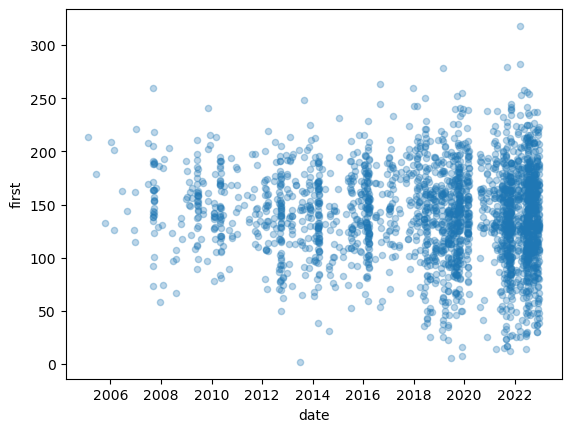

In [9]:
ax = scores_train_df.plot.scatter(x='date', y='first', alpha=0.3)

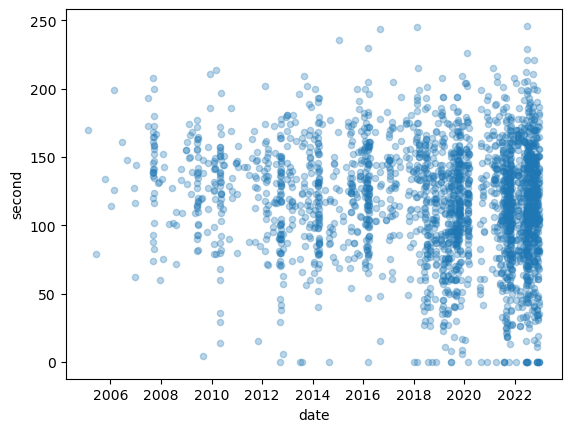

In [10]:
ax = scores_train_df.plot.scatter(x='date', y='second', alpha=0.3)

For both plots, there is no clear trend in terms of scores generally increasing or decreasing, other than a general spread both higher and lower. There are clearly more matches with every passing year. The highest values seen are all in first innings, which makes sense as the second innings is limited by the first. The 0s in the second innings are matches where the second innings was not played.

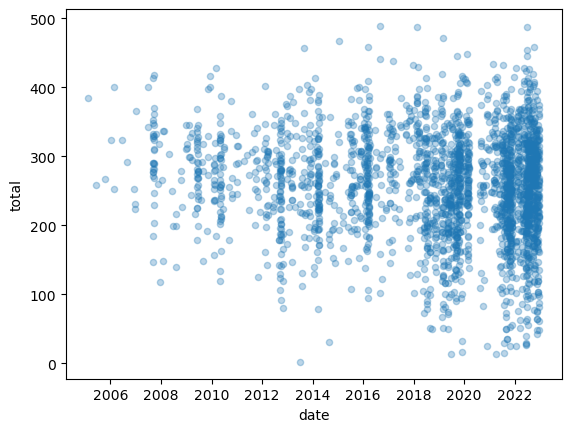

In [11]:
ax = scores_train_df.plot.scatter(x='date', y='total', alpha=0.3)

Looking at the total runs in a match, between 2005 and 2018 there are very few matches with under 100 runs. There are definitely a fairly large number in the more recent years.

Also notable, is the distribution of matches through time. The particularly dense vertical lines are correspond to major tournaments. There were Men's World Cups in 2007, 2009, 2010, 2012, 2014, 2016, 2021 and 2022. This makes the density increase between 2018 and 2020 interesting, but the starkness of this is exacerpated by the forced gap in 2020. It is likely there are simply many more matches from 2018 onwards.

In [12]:
scores_train_df['year'] = scores_train_df['date'].dt.year
scores_year = scores_train_df.groupby(['year'])[['first', 'second', 'total']].mean()

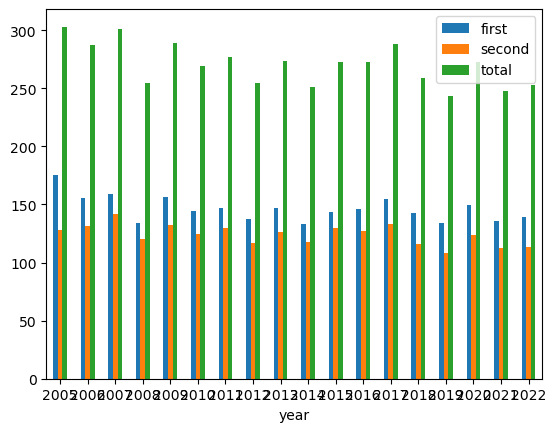

In [13]:
ax = scores_year.plot.bar(rot=0)

Looking at the averages, they decrease slightly over time. But with significant year on year variation, rather than a year on year decrease. Without looking at the match results, it is not possible to say whether this means that lower scores become more or less likely to win.